In [1]:
!pip install torchmetrics
!pip install thop
!pip install yacs
!pip install kornia
!pip install torch torchvision thop opencv-python tqdm numpy scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 94.3 MB/s eta 0:00:00


In [2]:

%cd content

[Errno 2] No such file or directory: 'content'
/content


In [3]:
#import

import zipfile
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from PIL import Image
import os
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
from thop import profile, clever_format

import torch.nn as nn
import torch.optim as optim

from torchmetrics import JaccardIndex
import torch.nn.functional as F
import random

from tqdm import tqdm

import kornia
import time
import logging
from torch.utils import data, model_zoo



import argparse
import torch
import torch.nn as nn
from torch.utils import data, model_zoo
import numpy as np
import pickle
from torch.autograd import Variable
import torch.optim as optim
import scipy.misc
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys
import os
import os.path as osp
import matplotlib.pyplot as plt
import random

In [4]:
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip

--2025-01-20 13:38:36--  https://zenodo.org/record/5706578/files/Train.zip
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/5706578/files/Train.zip [following]
--2025-01-20 13:38:37--  https://zenodo.org/records/5706578/files/Train.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 4021669263 (3.7G) [application/octet-stream]
Saving to: ‘Train.zip’

Train.zip           100%[===================>]   3.75G  19.3MB/s    in 3m 28s  

2025-01-20 13:42:05 (18.4 MB/s) - ‘Train.zip’ saved [4021669263/4021669263]

--2025-01-20 13:42:05--  https://zenodo.org/record/5706578/files/Val.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request 

In [5]:
!wget https://zenodo.org/records/14606189/files/PIDNet_S_ImageNet.pth.tar

--2025-01-20 13:44:11--  https://zenodo.org/records/14606189/files/PIDNet_S_ImageNet.pth.tar
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.48.194, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38061375 (36M) [application/octet-stream]
Saving to: ‘PIDNet_S_ImageNet.pth.tar’

PIDNet_S_ImageNet.p 100%[===================>]  36.30M  11.3MB/s    in 3.2s    

2025-01-20 13:44:15 (11.3 MB/s) - ‘PIDNet_S_ImageNet.pth.tar’ saved [38061375/38061375]



In [6]:
# Define file paths
train_zip = "Train.zip"
val_zip = "Val.zip"

# Extract Train.zip
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("Train")

# Extract Val.zip
with zipfile.ZipFile(val_zip, 'r') as zip_ref:
    zip_ref.extractall("Val")

# Verify the extracted folders
print("Train Directory Contents:", os.listdir("Train"))
print("Val Directory Contents:", os.listdir("Val"))

Train Directory Contents: ['Train']
Val Directory Contents: ['Val']


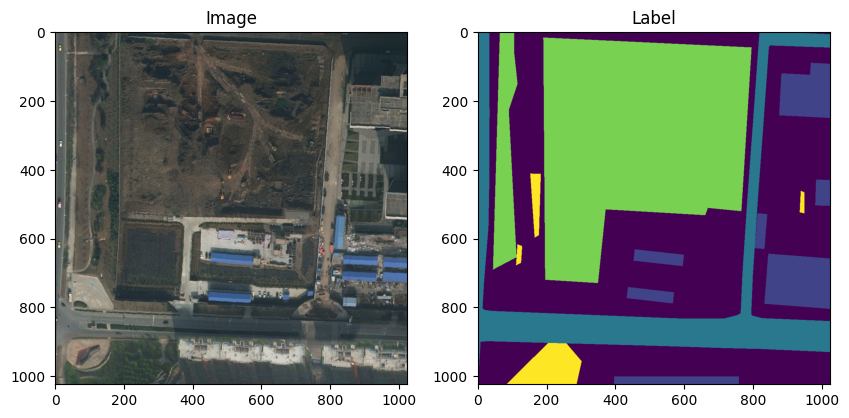

In [7]:
# Load and visualize an image and its corresponding label
image_path = "Train/Train/Urban/images_png/1366.png"
label_path = "Train/Train/Urban/masks_png/1366.png"

image = Image.open(image_path)
label = Image.open(label_path)

# Display
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Label")
plt.imshow(label)
plt.show()

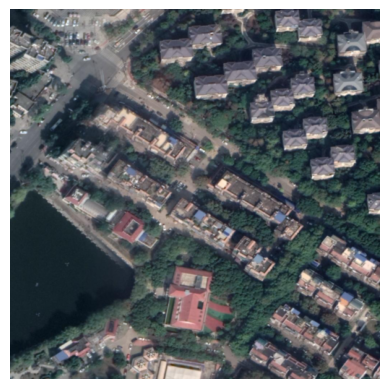

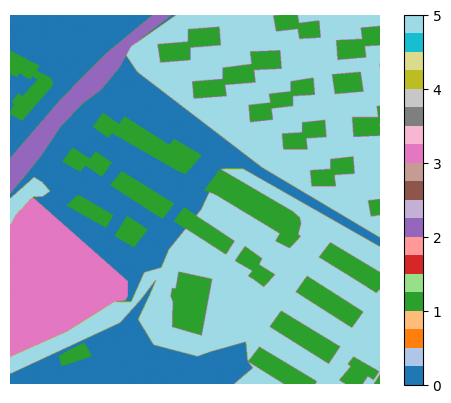

In [8]:
#TASK 3.b

COLOR_MAP = {
    'Background': 0.00392157,
    'Building': 0.00784314,
    'Road': 0.01176471,
    'Water': 0.01568628,
    'Barren': 0.01960784,
    'Forest': 0.02352941,
    'Agricultural': 0.02745098
}

LABEL_MAP = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)

# Tolerance-based color to label conversion
def color_to_one_hot(mask, label_map, tolerance=0.001, num_classes=7):
    mask = np.asarray(mask, dtype=np.float32)
    if len(mask.shape) == 2:  # Ensure channel dimension exists
        mask = np.expand_dims(mask, axis=0)  # Convert [H, W] to [1, H, W]

    one_hot_mask = np.zeros((num_classes, mask.shape[1], mask.shape[2]), dtype=np.float32)

    for class_name, class_index in label_map.items():
        color_value = COLOR_MAP[class_name]
        # Match pixels with the grayscale value within the tolerance
        matches = np.abs(mask - color_value) < tolerance
        one_hot_mask[class_index, np.squeeze(matches, axis=0)] = 1.0

    return torch.from_numpy(one_hot_mask)


# Define a function to denormalize the image
def denormalize(tensor, mean, std):
    """ Denormalize the tensor back to the [0, 1] range for visualization. """
    for i in range(len(mean)):
        tensor[i] = tensor[i] * std[i] + mean[i]
    return tensor

def show_image(image_tensor):
    """ Display a transformed image using matplotlib. """
    image_tensor = denormalize(image_tensor, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Denormalize the image
    image = image_tensor.permute(1, 2, 0).numpy()  # Convert to HxWxC format
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

def show_mask(mask_tensor, num_classes=7):
    """ Display the mask using matplotlib. """
    # Convert the one-hot mask to the label mask (indices of the highest value per pixel)
    mask = mask_tensor.squeeze().cpu().numpy()  # Remove the batch dimension and convert to numpy
    label_mask = np.argmax(mask, axis=0)  # Get the class index with the highest value for each pixel

    plt.imshow(label_mask, cmap='tab20')  # Use a colormap suitable for categorical data
    plt.colorbar()  # Optionally add a color bar
    plt.axis('off')  # Hide axes
    plt.show()


def colorJitter(colorJitter, img_mean, data = None, target = None, s=0.25):
    # s is the strength of colorjitter
    #colorJitter
    if not (data is None):
        if data.shape[1]==3:
            if colorJitter > 0.2:
                img_mean, _ = torch.broadcast_tensors(img_mean.unsqueeze(0).unsqueeze(2).unsqueeze(3), data)
                seq = nn.Sequential(kornia.augmentation.ColorJitter(brightness=s,contrast=s,saturation=s,hue=s))
                data = (data+img_mean)/255
                data = seq(data)
                data = (data*255-img_mean).float()
    return data, target

def gaussian_blur(blur, data = None, target = None):
    if not (data is None):
        if data.shape[1]==3:
            if blur > 0.5:
                sigma = np.random.uniform(0.15,1.15)
                kernel_size_y = int(np.floor(np.ceil(0.1 * data.shape[2]) - 0.5 + np.ceil(0.1 * data.shape[2]) % 2))
                kernel_size_x = int(np.floor(np.ceil(0.1 * data.shape[3]) - 0.5 + np.ceil(0.1 * data.shape[3]) % 2))
                kernel_size = (kernel_size_y, kernel_size_x)
                seq = nn.Sequential(kornia.filters.GaussianBlur2d(kernel_size=kernel_size, sigma=(sigma, sigma)))
                data = seq(data)
    return data, target

def strongTransform(parameters, data=None, target=None):
    assert ((data is not None) or (target is not None))
    # data, target = transformsgpu.oneMix(mask = parameters["Mix"], data = data, target = target)
    data, target = colorJitter(colorJitter = parameters["ColorJitter"], img_mean = torch.from_numpy(IMG_MEAN.copy()).cuda(), data = data, target = target)
    data, target = gaussian_blur(blur = parameters["GaussianBlur"], data = data, target = target)
    # data, target = transformsgpu.flip(flip = parameters["flip"], data = data, target = target)
    return data, target



class LoveDADataset(Dataset):
    def __init__(self, root_dir, split='train', transform_image=None, transform_label=None, subdir="Rural", aug1=False, aug2=False):
        self.root_dir = root_dir
        self.split = split
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.aug1 = aug1
        self.aug2 = aug2
        self.image_paths = []
        self.label_paths = []

        image_dir = os.path.join(root_dir, split, subdir, 'images_png')
        label_dir = os.path.join(root_dir, split, subdir, 'masks_png')

        for f in os.listdir(image_dir):
            if f.endswith('.png'):
                self.image_paths.append(os.path.join(image_dir, f))
                self.label_paths.append(os.path.join(label_dir, f))

    def __len__(self):
        original_length = len(self.image_paths)
        if self.aug1 and self.aug2:
            return original_length * 2
        elif self.aug1 or self.aug2:
            return int(original_length * 1.5)
        else:
            return original_length


    def __getitem__(self, idx):
        original_length = len(self.image_paths)

        # Calcola l'indice originale nel dataset
        idx = idx % original_length

        aug_1 = False
        aug_2 = False
        if(idx < original_length):
            aug_1 = False
            aug_2 = False

        elif(idx >= original_length):
            if(random.random() < 0.5):
                if(self.aug1):
                    aug_1 = True
                    aug_2 = False
                elif(self.aug2):
                    aug_1 = False
                    aug_2 = True

            else:
                if (self.aug2):
                    aug_1 = False
                    aug_2 = True
                elif(self.aug1):
                    aug_1 = True
                    aug_2 = False



        # Carica l'immagine e la maschera
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = Image.open(self.label_paths[idx]).convert("L")

        image_np = np.array(image)
        label_np = np.array(label)

        # Seed per garantire coerenza tra immagine e maschera
        seed = np.random.randint(2147483647)

        # Applica augmentazione se abilitata
        if self.aug1 and aug_1:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            transform_aug1 = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(30)
            ])
            image = Image.fromarray(image_np)
            image = transform_aug1(image)
            image_np = np.array(image)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            label = Image.fromarray(label_np)
            label = transform_aug1(label)
            label_np = np.array(label)

        if self.aug2 and aug_2:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            # transform_aug2 = transforms.Compose([
            #     #sigma=(0.1, 5) indica un intervallo di valori tra 0.1 e 5, quindi la sfocatura potrebbe variare in base a come viene applicata.
            #     transforms.GaussianBlur(kernel_size=(5,9), sigma=( 0.1, 5)) #valori di dimensioni (5, 9), che significa che il filtro si estende su un'area di 5x9 pixel.
            # ])
            strong_parameters = {}
            strong_parameters["ColorJitter"] = random.uniform(0, 1)
            strong_parameters["GaussianBlur"] = random.uniform(0, 1)


            image = Image.fromarray(image_np)
            image, _ = strongTransform(strong_parameters, image, None)
            image_np = np.array(image)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            label = Image.fromarray(label_np)
            # label = transform_aug2(label)
            label_np = np.array(label)

        # Trasformazioni opzionali per immagine e maschera
        if self.transform_image:
            transform_image_alb = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            image = Image.fromarray(image_np)
            image = transform_image_alb(image)

        if self.transform_label:
            transform_label_alb = transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor()
            ])
            label = Image.fromarray(label_np)
            label = transform_label_alb(label).squeeze(0)
            label = color_to_one_hot(label, LABEL_MAP)

        return image,label

# Define transformations without augmentations
transform_image = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

transform_label = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Set augmentation flags
AUG1 = True
AUG2 = True

BATCH_SIZE = 16 #or 32, or 64 ...
NUM_WORKERS = 2 # Number of cpu cores
PIN_MEMORY = True
PERSISTENT_WORKERS = False # Set true if you have persistent workers issues
# Create dataset and dataloader with augmentations
train_dataset = LoveDADataset(root_dir='Train/', split='Train', transform_image=transform_image, transform_label=transform_label, subdir='Urban', aug1=AUG1, aug2=AUG2)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)
val_dataset = LoveDADataset(root_dir='Val/', split='Val', transform_image=transform_image, transform_label=transform_label, subdir='Urban')




val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

target_dataset = LoveDADataset(root_dir='Train/', split='Train', transform_image=transform_image, transform_label=transform_label, subdir='Rural')
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Visualize the first batch of images
for i, (image, label) in enumerate(train_loader):
    if i == 0:  # Show only the first batch
        show_image(image[0])  # Access the first image of the batch
        show_mask(label[0])
        break


# # Definisci una dimensione più piccola per il subset (ad esempio 10% del dataset)
# subset_size = 200  # Usa solo i primi 100 campioni per il test

# # Usa torch.utils.data.Subset per ottenere un subset casuale dei dati
# subset_indices = torch.randperm(len(train_loader.dataset)).tolist()[:subset_size]

# train_subset = torch.utils.data.Subset(train_loader.dataset, subset_indices)

# target_subset= torch.utils.data.Subset(target_loader.dataset, subset_indices)

# val_subset= torch.utils.data.Subset(val_loader.dataset, subset_indices)

# # Crea un DataLoader per il subset
# train_subset_loader = DataLoader(train_subset, batch_size=2, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)

# target_subset_loader = DataLoader(target_subset, batch_size=2, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)

# val_subset_loader = DataLoader(val_subset, batch_size=2, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=PERSISTENT_WORKERS)



# for i, (image, label) in enumerate(train_subset_loader):
#     if i == 0:  # Show only the first batch
#         show_image(image[0])  # Access the first image of the batch
#         show_mask(label[0])
#         break


# target_loader=target_subset_loader

# val_loader=val_subset_loader

# train_loader=train_subset_loader

Visualizing image 1


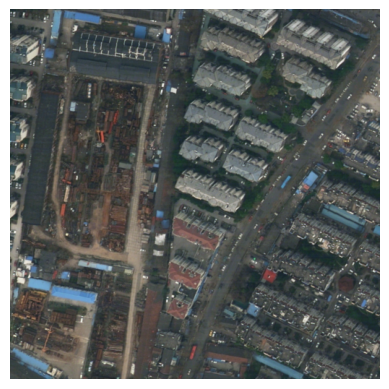

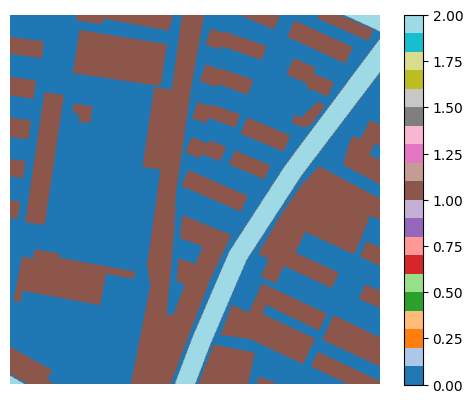

In [9]:
# Funzione per visualizzare immagini con augmentations applicate
def visualize_augmented_images(dataloader, num_images=1):
    """
    Visualizza immagini con augmentations applicate.
    Args:
        dataloader: Il DataLoader dal quale prelevare le immagini.
        num_images: Numero di immagini da visualizzare.
    """
    count = 0
    for images, labels in dataloader:
        for i in range(images.size(0)):
            if count >= num_images:
                return  # Mostra solo il numero richiesto di immagini
            print(f"Visualizing image {count + 1}")
            show_image(images[i])  # Visualizza l'immagine
            show_mask(labels[i])  # Visualizza la maschera
            count += 1

# Visualizza immagini con augmentations dal train_loader
visualize_augmented_images(train_loader, num_images=1)

In [10]:
!git clone https://github.com/XuJiacong/PIDNet.git
%cd content

Cloning into 'PIDNet'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 386 (delta 131), reused 125 (delta 125), pack-reused 193 (from 1)
Receiving objects: 100% (386/386), 212.80 MiB | 33.07 MiB/s, done.
Resolving deltas: 100% (184/184), done.
[Errno 2] No such file or directory: 'content'
/content


In [11]:
import sys
%cd "/content/PIDNet/models"
sys.path.append('/content/PIDNet/')
# sys.path.append('/content/PIDNet/models/')


/content/PIDNet/models


In [12]:
from model_utils import BasicBlock, Bottleneck, segmenthead, DAPPM, PAPPM, PagFM, Bag, Light_Bag
from utils.criterion import CrossEntropy, OhemCrossEntropy, BondaryLoss

In [13]:

%cd "/content"

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x, x_, x_extra_d]
        else:
            return x_


def get_seg_model(name, num_classes, imgnet_pretrained, model_pth):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=True)



    if imgnet_pretrained:
        print("vamos")
        pretrained_state = torch.load(model_pth, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        model.load_state_dict(model_dict, strict = False)
        print(msg)
        logging.info(msg)
        logging.info('Over!!!')

    else:
        print("namos")

        pretrained_dict = torch.load(model_pth, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_seg_model(name='pidnet_s', num_classes=7, imgnet_pretrained=True, model_pth='PIDNet_S_ImageNet.pth.tar').to(device)
# model.load_state_dict( torch.load('best_pidnet_model.pth'))



/content
vamos


<ipython-input-13-07b6ec5b8c14>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(model_pth, map_location='cpu')['state_dict']


Loaded 302 parameters!


In [14]:
!git clone https://github.com/wasidennis/AdaptSegNet.git
sys.path.append('/content/AdaptSegNet')

Cloning into 'AdaptSegNet'...
remote: Enumerating objects: 281, done.
remote: Total 281 (delta 0), reused 0 (delta 0), pack-reused 281 (from 1)
Receiving objects: 100% (281/281), 2.98 MiB | 6.95 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [15]:
from model.discriminator import FCDiscriminator
from dataset.gta5_dataset import GTA5DataSet
from dataset.cityscapes_dataset import cityscapesDataSet
from utils.criterion import CrossEntropy, OhemCrossEntropy, BondaryLoss

In [16]:

num_classes=7
LEARNING_RATE_D = 1e-4
learning_rate_D = 5e-4


bce_loss = torch.nn.BCEWithLogitsLoss()

model_D1 = FCDiscriminator(num_classes=7)
optimizer_D1 = optim.Adam(model_D1.parameters(), lr=learning_rate_D, betas=(0.9, 0.99))
optimizer_D1.zero_grad()

model_D1.train()
model_D1.cuda(device)

FCDiscriminator(
  (conv1): Conv2d(7, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (classifier): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
)

In [17]:
torch.cuda.reset_max_memory_allocated() #in caso di 'cuda out of memory'
torch.cuda.reset_peak_memory_stats()
import gc
gc.collect() #clear cpu memory
import torch
torch.cuda.empty_cache() #clear gpu memory #runna più volte

/usr/local/lib/python3.11/dist-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [18]:

# per sicurezza

learning_rate = 0.001

# model = get_seg_model(name='pidnet_s', num_classes=7, imgnet_pretrained=True, model_pth='PIDNet_S_ImageNet.pth.tar').to(device)


# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # You can adjust the learning rate

# random - experience
class_weights = torch.FloatTensor([0.8373, 0.918, 0.866, 1.0345,
                                        1.0166, 0.9969, 0.9754]).cuda()

# Define the loss function
# criterion = nn.CrossEntropyLoss()
criterion = OhemCrossEntropy(ignore_label=255,
                                        thres=0.9,
                                        min_kept=131072,
                                        weight=class_weights)

# Define mIoU metric
jaccard = JaccardIndex(task="multiclass", num_classes=7).to('cuda')  # intersection over union. Directly measures the overlap between predicted segmentation and ground truth.


# Training loop
num_epochs = 20 #20
best_miou = 0.0

lambda_adv_1 = 0.0005

def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1,  max_iter=300, power=0.9):
    """Polynomial decay of learning rate
    :param init_lr is base learning rate
    :param iter is a current iteration
    :param lr_decay_iter how frequently decay occurs, default is 1
    :param max_iter is number of maximum iterations
    :param power is a polymomial power

    """
    # if iter % lr_decay_iter or iter > max_iter:
    # 	return optimizer

    lr = init_lr*(1 - iter/max_iter)**power
    optimizer.param_groups[0]['lr'] = lr
    return lr
    # return lr



def evaluate(images,masks):
    val_miou = 0.0
    val_class_iou = torch.zeros(len(LABEL_MAP)).to('cuda')  # Store IoU per class
    val_class_counts = torch.zeros(len(LABEL_MAP)).to('cuda')  # To track number of pixels for each class

    images, masks = images.to('cuda'), masks.to('cuda')

    # Forward pass
    outputs = model(images)  # [batch_size, num_classes, 64, 64]
    main_output = outputs[1]
    preds = torch.argmax(main_output, dim=1)  # [batch_size, 64, 64]

    # Convert masks to class indices format if one-hot encoded
    if masks.ndim == 4:  # [batch_size, num_classes, height, width]
        masks = masks.argmax(dim=1)  # [batch_size, height, width]

    # Resize preds to match the size of the masks
    preds_resized = F.interpolate(preds.unsqueeze(1).float(), size=masks.shape[1:], mode='nearest').squeeze(1).long()

    # Calculate per-class IoU
    for c, class_name in LABEL_MAP.items():  # Iterate over LABEL_MAP classes
        true_class = (masks == class_name)
        pred_class = (preds_resized == class_name)

        intersection = torch.sum(true_class & pred_class).float()
        union = torch.sum(true_class | pred_class).float()

        if union != 0:
            val_class_iou[class_name] += intersection / union
        val_class_counts[class_name] += 1

    # Calculate overall mIoU for this batch
    val_miou += jaccard(preds_resized, masks)

    return val_miou, val_class_iou



for epoch in range(num_epochs):
    model.train()
    model_D1.train()
    running_loss = 0.0
    counter = 0
    loss_D_epoch = 0

    loss_A_epoch = 0

    lr = poly_lr_scheduler(optimizer, learning_rate, iter=epoch, max_iter=20)
    lr_discriminator = poly_lr_scheduler(optimizer_D1, learning_rate_D, iter=epoch, max_iter=20)
    softmaxt = True

    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") # train_loader
    for images, masks in train_progress_bar:
        images, masks = images.to(device), masks.to(device)




        for param in model_D1.parameters():
                param.requires_grad = False


        try:
          target_images, _ = next(val_l)  # Get target domain data
          target_images = target_images.to('cuda')
        except:

          val_l = iter(target_loader)
          target_images, _ = next(val_l)  # Get target domain data
          target_images = target_images.to('cuda')


        optimizer.zero_grad()
        optimizer_D1.zero_grad()

        # How to use softmax output_discriminator = model_D(F.softmax(output_target, dim=1))
        # 0 train segmentation net
        masks = masks.argmax(dim=1)
        outputs = model(images)  # Main segmentation output
        outputs_resized = F.interpolate(outputs[1], size=masks.shape[1:], mode='bilinear', align_corners=False)
        seg_loss = criterion(outputs_resized, masks)
        seg_loss.backward()


        # Adversarial loss for target domain
        outputs_target = model(target_images) # Main segmentation output for target
        outputs_target_resized = F.interpolate(outputs_target[1], size=masks.shape[1:], mode='bilinear', align_corners=False)
        out_t = outputs_target_resized
        if softmaxt== True:
            out_t = F.softmax(out_t, dim=1)
        D_out_target_adv = model_D1((out_t))

        adv_loss = bce_loss(D_out_target_adv, torch.ones_like(D_out_target_adv)) * lambda_adv_1

        loss_A_epoch+=adv_loss

        adv_loss.backward()

        # 1. Train Discriminator

        # bring back requires_grad
        for param in model_D1.parameters():
            param.requires_grad = True


        # Forward pass for source domain
        out_s = (F.interpolate(outputs[1], size=masks.shape[1:], mode='bilinear', align_corners=False).detach())
        if softmaxt== True:
            out_s = F.softmax(out_s, dim=1)
        D_out_source = model_D1(out_s)
        D_loss_source = bce_loss((D_out_source), torch.ones_like(D_out_source))  # Label 1 for source
        loss_D_epoch += D_loss_source.item()
        D_loss_source.backward()

        # Forward pass for target domain

        out_t = outputs_target_resized.detach()
        if softmaxt== True:
            out_t = F.softmax(out_t, dim=1)
        D_out_target = model_D1(out_t)
        D_loss_target = bce_loss((D_out_target), torch.zeros_like(D_out_target))  # Label 0 for target
        loss_D_epoch += D_loss_target.item()
        D_loss_target.backward()

        optimizer_D1.step()
        optimizer.step()


        counter+=1
        # adjust_learning_rate(optimizer, counter)
        # adjust_learning_rate_D(optimizer_D1, counter)


        running_loss += seg_loss.item()

        # Update tqdm progress bar with real-time loss using set_postfix
        train_progress_bar.set_postfix({
          "seg_loss": f"{seg_loss.item():.4f}",
          "adv_loss": f"{adv_loss:.4f}",
          "D_loss": f"{(D_loss_source.item() + D_loss_target.item()):.4f}",
          "lr": f"{optimizer.param_groups[0]['lr']:.4f}",
          "lr_D": f"{optimizer_D1.param_groups[0]['lr']:.4f}"
        })

    avg_loss = running_loss / len(train_loader) #len(train_subset_loader) #len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Seg _ Loss: {avg_loss:.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}] Adv _ Loss: {loss_A_epoch/len(train_loader):.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}]  Disc _ Loss: {loss_D_epoch/len(train_loader):.4f}")


    # Clear GPU memory
    torch.cuda.empty_cache()

    # Validation loop
    model.eval()
    val_miou = 0.0
    target_val_miou = 0.0
    val_class_iou = torch.zeros(len(LABEL_MAP)).to('cuda')  # Store IoU per class
    val_class_counts = torch.zeros(len(LABEL_MAP)).to('cuda')  # To track number of pixels for each class

    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            miou, val_class_iou= evaluate(images,masks)
            val_miou += miou

    with torch.no_grad():
        for images, masks in tqdm(target_loader):
            miou, target_class_iou= evaluate(images,masks)

            target_val_miou += miou


    # Average metrics
    val_miou /= len(val_loader)

    # Calculate average IoU for each class
    avg_class_iou = val_class_iou / val_class_counts
    target_miou= target_val_miou / len(target_loader)

    # Print validation metrics at the end of each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation mIoU: {val_miou:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] - Target mIoU: {target_miou:.4f}")



    print(f"Epoch [{epoch+1}/{num_epochs}] - Per-Class IoU: {dict(zip(LABEL_MAP.keys(), target_class_iou.tolist()))}")

    # Save the best model
    if target_miou > best_miou:
        best_miou = target_miou
        torch.save(model.state_dict(), 'best_pidnet_model.pth')

print(f"Best Validation mIoU: {best_miou:.4f}")




Epoch 1/20: 100%|██████████| 145/145 [06:41<00:00,  2.77s/batch, seg_loss=0.5199, adv_loss=0.0006, D_loss=1.2879, lr=0.0010, lr_D=0.0005]


Epoch [1/20] Seg _ Loss: 0.6100
Epoch [1/20] Adv _ Loss: 0.0004
Epoch [1/20]  Disc _ Loss: 1.3487


100%|██████████| 86/86 [01:49<00:00,  1.27s/it]


Epoch [1/20] - Validation mIoU: 0.2494
Epoch [1/20] - Target mIoU: 0.2903
Epoch [1/20] - Per-Class IoU: {'Background': 0.5446318984031677, 'Building': 0.359500914812088, 'Road': 0.04249686002731323, 'Water': 0.35801371932029724, 'Barren': 0.0004616500809788704, 'Forest': 0.17798829078674316, 'Agricultural': 0.4077136516571045}


Epoch 2/20: 100%|██████████| 145/145 [06:34<00:00,  2.72s/batch, seg_loss=0.3718, adv_loss=0.0007, D_loss=1.1593, lr=0.0010, lr_D=0.0005]


Epoch [2/20] Seg _ Loss: 0.4000
Epoch [2/20] Adv _ Loss: 0.0006
Epoch [2/20]  Disc _ Loss: 1.2036


100%|██████████| 86/86 [01:45<00:00,  1.23s/it]


Epoch [2/20] - Validation mIoU: 0.2535
Epoch [2/20] - Target mIoU: 0.2893
Epoch [2/20] - Per-Class IoU: {'Background': 0.2965039610862732, 'Building': 0.2801303565502167, 'Road': 0.029171349480748177, 'Water': 0.4437468647956848, 'Barren': 0.008626499213278294, 'Forest': 0.4467518925666809, 'Agricultural': 0.13050414621829987}


Epoch 3/20: 100%|██████████| 145/145 [06:39<00:00,  2.76s/batch, seg_loss=0.4464, adv_loss=0.0005, D_loss=1.1993, lr=0.0009, lr_D=0.0005]


Epoch [3/20] Seg _ Loss: 0.3768
Epoch [3/20] Adv _ Loss: 0.0006
Epoch [3/20]  Disc _ Loss: 1.1282


100%|██████████| 86/86 [01:49<00:00,  1.27s/it]


Epoch [3/20] - Validation mIoU: 0.2607
Epoch [3/20] - Target mIoU: 0.2671
Epoch [3/20] - Per-Class IoU: {'Background': 0.27640601992607117, 'Building': 0.48333531618118286, 'Road': 0.5009676814079285, 'Water': 0.24169926345348358, 'Barren': 0.00027335245977155864, 'Forest': 0.5264626741409302, 'Agricultural': 0.09129901230335236}


Epoch 4/20: 100%|██████████| 145/145 [06:32<00:00,  2.70s/batch, seg_loss=0.4040, adv_loss=0.0006, D_loss=1.1866, lr=0.0009, lr_D=0.0004]


Epoch [4/20] Seg _ Loss: 0.3596
Epoch [4/20] Adv _ Loss: 0.0006
Epoch [4/20]  Disc _ Loss: 1.1089


100%|██████████| 86/86 [01:53<00:00,  1.32s/it]


Epoch [4/20] - Validation mIoU: 0.2328
Epoch [4/20] - Target mIoU: 0.2453
Epoch [4/20] - Per-Class IoU: {'Background': 0.1509377807378769, 'Building': 0.02385127730667591, 'Road': 0.027141807600855827, 'Water': 0.2663075029850006, 'Barren': 0.040091101080179214, 'Forest': 0.2763347923755646, 'Agricultural': 0.2398987114429474}


Epoch 5/20: 100%|██████████| 145/145 [06:31<00:00,  2.70s/batch, seg_loss=0.3486, adv_loss=0.0005, D_loss=1.0598, lr=0.0008, lr_D=0.0004]


Epoch [5/20] Seg _ Loss: 0.3506
Epoch [5/20] Adv _ Loss: 0.0007
Epoch [5/20]  Disc _ Loss: 1.0846


100%|██████████| 86/86 [01:44<00:00,  1.21s/it]


Epoch [5/20] - Validation mIoU: 0.2799
Epoch [5/20] - Target mIoU: 0.2584
Epoch [5/20] - Per-Class IoU: {'Background': 0.19231551885604858, 'Building': 0.13844729959964752, 'Road': 0.024583496153354645, 'Water': 0.41440731287002563, 'Barren': 0.15072442591190338, 'Forest': 0.337342232465744, 'Agricultural': 0.11599858850240707}


Epoch 6/20: 100%|██████████| 145/145 [06:30<00:00,  2.69s/batch, seg_loss=0.3793, adv_loss=0.0007, D_loss=1.3273, lr=0.0008, lr_D=0.0004]


Epoch [6/20] Seg _ Loss: 0.3325
Epoch [6/20] Adv _ Loss: 0.0007
Epoch [6/20]  Disc _ Loss: 1.0621


100%|██████████| 86/86 [01:45<00:00,  1.23s/it]


Epoch [6/20] - Validation mIoU: 0.2577
Epoch [6/20] - Target mIoU: 0.2588
Epoch [6/20] - Per-Class IoU: {'Background': 0.34414225816726685, 'Building': 0.02417193353176117, 'Road': 0.029221968725323677, 'Water': 0.39628350734710693, 'Barren': 0.00836015585809946, 'Forest': 0.2876743674278259, 'Agricultural': 0.22097937762737274}


Epoch 7/20: 100%|██████████| 145/145 [06:26<00:00,  2.67s/batch, seg_loss=0.3592, adv_loss=0.0006, D_loss=1.0824, lr=0.0007, lr_D=0.0004]


Epoch [7/20] Seg _ Loss: 0.3218
Epoch [7/20] Adv _ Loss: 0.0008
Epoch [7/20]  Disc _ Loss: 1.0297


100%|██████████| 86/86 [01:46<00:00,  1.24s/it]


Epoch [7/20] - Validation mIoU: 0.2536
Epoch [7/20] - Target mIoU: 0.2678
Epoch [7/20] - Per-Class IoU: {'Background': 0.34598594903945923, 'Building': 0.034893084317445755, 'Road': 0.010913455858826637, 'Water': 0.4700114130973816, 'Barren': 0.0, 'Forest': 0.014088845811784267, 'Agricultural': 0.005032186396420002}


Epoch 8/20: 100%|██████████| 145/145 [06:47<00:00,  2.81s/batch, seg_loss=0.3262, adv_loss=0.0011, D_loss=0.9382, lr=0.0007, lr_D=0.0003]


Epoch [8/20] Seg _ Loss: 0.3133
Epoch [8/20] Adv _ Loss: 0.0008
Epoch [8/20]  Disc _ Loss: 0.9734


100%|██████████| 86/86 [01:41<00:00,  1.18s/it]


Epoch [8/20] - Validation mIoU: 0.2862
Epoch [8/20] - Target mIoU: 0.2980
Epoch [8/20] - Per-Class IoU: {'Background': 0.34533050656318665, 'Building': 0.10364117473363876, 'Road': 0.4033285081386566, 'Water': 0.5519137978553772, 'Barren': 0.0176079124212265, 'Forest': 0.3458159267902374, 'Agricultural': 0.16488787531852722}


Epoch 9/20: 100%|██████████| 145/145 [06:22<00:00,  2.64s/batch, seg_loss=0.3207, adv_loss=0.0010, D_loss=1.0786, lr=0.0006, lr_D=0.0003]


Epoch [9/20] Seg _ Loss: 0.3079
Epoch [9/20] Adv _ Loss: 0.0009
Epoch [9/20]  Disc _ Loss: 0.9270


100%|██████████| 86/86 [01:43<00:00,  1.20s/it]


Epoch [9/20] - Validation mIoU: 0.2777
Epoch [9/20] - Target mIoU: 0.3059
Epoch [9/20] - Per-Class IoU: {'Background': 0.41577833890914917, 'Building': 0.13407956063747406, 'Road': 0.003580126678571105, 'Water': 0.3271559476852417, 'Barren': 0.08280465006828308, 'Forest': 0.497349351644516, 'Agricultural': 0.12262508273124695}


Epoch 10/20: 100%|██████████| 145/145 [06:19<00:00,  2.62s/batch, seg_loss=0.2934, adv_loss=0.0011, D_loss=0.9654, lr=0.0006, lr_D=0.0003]


Epoch [10/20] Seg _ Loss: 0.3112
Epoch [10/20] Adv _ Loss: 0.0009
Epoch [10/20]  Disc _ Loss: 0.9357


100%|██████████| 86/86 [01:46<00:00,  1.24s/it]


Epoch [10/20] - Validation mIoU: 0.2713
Epoch [10/20] - Target mIoU: 0.2779
Epoch [10/20] - Per-Class IoU: {'Background': 0.26637357473373413, 'Building': 0.2810934782028198, 'Road': 0.16590631008148193, 'Water': 0.5712563395500183, 'Barren': 0.004389652982354164, 'Forest': 0.17631842195987701, 'Agricultural': 0.1714266836643219}


Epoch 11/20: 100%|██████████| 145/145 [06:23<00:00,  2.64s/batch, seg_loss=0.3720, adv_loss=0.0011, D_loss=0.9815, lr=0.0005, lr_D=0.0003]


Epoch [11/20] Seg _ Loss: 0.3086
Epoch [11/20] Adv _ Loss: 0.0010
Epoch [11/20]  Disc _ Loss: 0.8778


100%|██████████| 86/86 [01:51<00:00,  1.29s/it]


Epoch [11/20] - Validation mIoU: 0.2869
Epoch [11/20] - Target mIoU: 0.2933
Epoch [11/20] - Per-Class IoU: {'Background': 0.34546640515327454, 'Building': 0.041322946548461914, 'Road': 0.2219957560300827, 'Water': 0.679663896560669, 'Barren': 0.0016534050228074193, 'Forest': 0.48956099152565, 'Agricultural': 0.17339636385440826}


Epoch 12/20: 100%|██████████| 145/145 [06:51<00:00,  2.84s/batch, seg_loss=0.3644, adv_loss=0.0013, D_loss=0.7626, lr=0.0005, lr_D=0.0002]


Epoch [12/20] Seg _ Loss: 0.3040
Epoch [12/20] Adv _ Loss: 0.0010
Epoch [12/20]  Disc _ Loss: 0.8421


100%|██████████| 86/86 [01:45<00:00,  1.22s/it]


Epoch [12/20] - Validation mIoU: 0.2987
Epoch [12/20] - Target mIoU: 0.3041
Epoch [12/20] - Per-Class IoU: {'Background': 0.3575369417667389, 'Building': 0.06613481789827347, 'Road': 0.0900244265794754, 'Water': 0.7845315933227539, 'Barren': 0.2517397701740265, 'Forest': 0.29003268480300903, 'Agricultural': 0.18190433084964752}


Epoch 13/20: 100%|██████████| 145/145 [06:30<00:00,  2.70s/batch, seg_loss=0.3249, adv_loss=0.0010, D_loss=0.9429, lr=0.0004, lr_D=0.0002]


Epoch [13/20] Seg _ Loss: 0.3019
Epoch [13/20] Adv _ Loss: 0.0011
Epoch [13/20]  Disc _ Loss: 0.8050


100%|██████████| 86/86 [01:47<00:00,  1.25s/it]


Epoch [13/20] - Validation mIoU: 0.2837
Epoch [13/20] - Target mIoU: 0.2854
Epoch [13/20] - Per-Class IoU: {'Background': 0.15159182250499725, 'Building': 0.028625696897506714, 'Road': 0.15362411737442017, 'Water': 0.5237160325050354, 'Barren': 0.23162907361984253, 'Forest': 0.22597089409828186, 'Agricultural': 0.24893613159656525}


Epoch 14/20: 100%|██████████| 145/145 [06:25<00:00,  2.66s/batch, seg_loss=0.3370, adv_loss=0.0013, D_loss=0.8282, lr=0.0004, lr_D=0.0002]


Epoch [14/20] Seg _ Loss: 0.2994
Epoch [14/20] Adv _ Loss: 0.0012
Epoch [14/20]  Disc _ Loss: 0.7751


100%|██████████| 86/86 [01:49<00:00,  1.28s/it]


Epoch [14/20] - Validation mIoU: 0.2771
Epoch [14/20] - Target mIoU: 0.2901
Epoch [14/20] - Per-Class IoU: {'Background': 0.27937573194503784, 'Building': 0.08476309478282928, 'Road': 0.22685371339321136, 'Water': 0.4613664150238037, 'Barren': 0.04459787905216217, 'Forest': 0.5012655854225159, 'Agricultural': 0.048331521451473236}


Epoch 15/20: 100%|██████████| 145/145 [06:38<00:00,  2.75s/batch, seg_loss=0.2824, adv_loss=0.0014, D_loss=0.6479, lr=0.0003, lr_D=0.0002]


Epoch [15/20] Seg _ Loss: 0.2980
Epoch [15/20] Adv _ Loss: 0.0012
Epoch [15/20]  Disc _ Loss: 0.7411


100%|██████████| 86/86 [01:46<00:00,  1.24s/it]


Epoch [15/20] - Validation mIoU: 0.2923
Epoch [15/20] - Target mIoU: 0.2968
Epoch [15/20] - Per-Class IoU: {'Background': 0.27779752016067505, 'Building': 0.43395018577575684, 'Road': 0.2998601198196411, 'Water': 0.6109912991523743, 'Barren': 0.034123510122299194, 'Forest': 0.5949817299842834, 'Agricultural': 0.35324984788894653}


Epoch 16/20: 100%|██████████| 145/145 [06:36<00:00,  2.74s/batch, seg_loss=0.3124, adv_loss=0.0012, D_loss=0.7757, lr=0.0003, lr_D=0.0001]


Epoch [16/20] Seg _ Loss: 0.2980
Epoch [16/20] Adv _ Loss: 0.0013
Epoch [16/20]  Disc _ Loss: 0.7264


100%|██████████| 86/86 [01:43<00:00,  1.21s/it]


Epoch [16/20] - Validation mIoU: 0.2882
Epoch [16/20] - Target mIoU: 0.2889
Epoch [16/20] - Per-Class IoU: {'Background': 0.4113547205924988, 'Building': 0.4365178048610687, 'Road': 0.11153467744588852, 'Water': 0.6857852339744568, 'Barren': 0.003324476070702076, 'Forest': 0.32405969500541687, 'Agricultural': 0.27186405658721924}


Epoch 17/20: 100%|██████████| 145/145 [06:28<00:00,  2.68s/batch, seg_loss=0.3230, adv_loss=0.0013, D_loss=0.8100, lr=0.0002, lr_D=0.0001]


Epoch [17/20] Seg _ Loss: 0.2986
Epoch [17/20] Adv _ Loss: 0.0013
Epoch [17/20]  Disc _ Loss: 0.7142


100%|██████████| 86/86 [01:45<00:00,  1.22s/it]


Epoch [17/20] - Validation mIoU: 0.2916
Epoch [17/20] - Target mIoU: 0.2913
Epoch [17/20] - Per-Class IoU: {'Background': 0.3446800112724304, 'Building': 0.0939868837594986, 'Road': 0.09241614490747452, 'Water': 0.27131515741348267, 'Barren': 0.02971530333161354, 'Forest': 0.27777060866355896, 'Agricultural': 0.2722175717353821}


Epoch 18/20: 100%|██████████| 145/145 [06:27<00:00,  2.67s/batch, seg_loss=0.3219, adv_loss=0.0013, D_loss=0.6822, lr=0.0002, lr_D=0.0001]


Epoch [18/20] Seg _ Loss: 0.2985
Epoch [18/20] Adv _ Loss: 0.0013
Epoch [18/20]  Disc _ Loss: 0.6987


100%|██████████| 86/86 [02:02<00:00,  1.42s/it]


Epoch [18/20] - Validation mIoU: 0.2865
Epoch [18/20] - Target mIoU: 0.2982
Epoch [18/20] - Per-Class IoU: {'Background': 0.3817605674266815, 'Building': 0.37406378984451294, 'Road': 0.28112131357192993, 'Water': 0.5343266725540161, 'Barren': 0.0009610226843506098, 'Forest': 0.2636222541332245, 'Agricultural': 0.4827522039413452}


Epoch 19/20: 100%|██████████| 145/145 [07:45<00:00,  3.21s/batch, seg_loss=0.2957, adv_loss=0.0016, D_loss=0.6126, lr=0.0001, lr_D=0.0001]


Epoch [19/20] Seg _ Loss: 0.2974
Epoch [19/20] Adv _ Loss: 0.0013
Epoch [19/20]  Disc _ Loss: 0.6776


100%|██████████| 86/86 [02:12<00:00,  1.54s/it]


Epoch [19/20] - Validation mIoU: 0.2776
Epoch [19/20] - Target mIoU: 0.2796
Epoch [19/20] - Per-Class IoU: {'Background': 0.36449602246284485, 'Building': 0.13814900815486908, 'Road': 0.2289496809244156, 'Water': 0.4080909192562103, 'Barren': 0.03056219220161438, 'Forest': 0.7011988162994385, 'Agricultural': 0.2803424894809723}


Epoch 20/20: 100%|██████████| 145/145 [07:48<00:00,  3.23s/batch, seg_loss=0.3197, adv_loss=0.0014, D_loss=0.9146, lr=0.0001, lr_D=0.0000]


Epoch [20/20] Seg _ Loss: 0.2972
Epoch [20/20] Adv _ Loss: 0.0014
Epoch [20/20]  Disc _ Loss: 0.6536


100%|██████████| 86/86 [02:22<00:00,  1.65s/it]

Epoch [20/20] - Validation mIoU: 0.2678
Epoch [20/20] - Target mIoU: 0.2679
Epoch [20/20] - Per-Class IoU: {'Background': 0.2408953160047531, 'Building': 0.07527995109558105, 'Road': 0.251830518245697, 'Water': 0.3247765600681305, 'Barren': 0.04650774225592613, 'Forest': 0.5405539870262146, 'Agricultural': 0.32370272278785706}
Best Validation mIoU: 0.3059


In [22]:
val_class_iou = torch.zeros(len(LABEL_MAP)).to('cuda')  # Store IoU per class

with torch.no_grad():
    for images, masks in tqdm(target_loader):
        val, iou= evaluate(images,masks)
        target_val_miou+=val
        val_class_iou += iou
val_class_iou /= len(target_loader)
print(f"Epoch [{epoch+1}/{num_epochs}] - Per-Class IoU: {dict(zip(LABEL_MAP.keys(), val_class_iou.tolist()))}")

100%|██████████| 86/86 [02:28<00:00,  1.73s/it]

Epoch [20/20] - Per-Class IoU: {'Background': 0.3314893841743469, 'Building': 0.09717684239149094, 'Road': 0.1497856229543686, 'Water': 0.3776525855064392, 'Barren': 0.07998885959386826, 'Forest': 0.3133525252342224, 'Agricultural': 0.04961540922522545}



Random Sample (Epoch 0)
Input Tensor:  torch.Size([1, 3, 512, 512])
Ground Truth:  torch.Size([7, 512, 512])
Model Output:  1


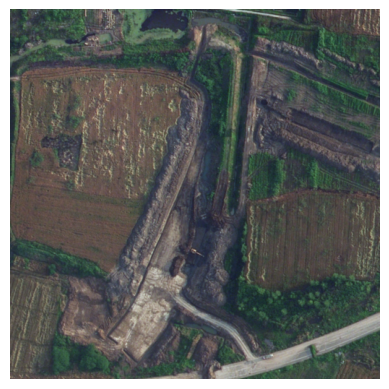

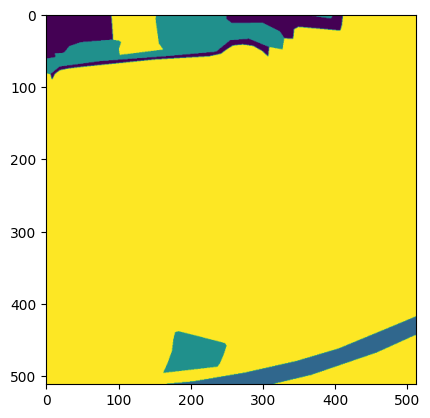

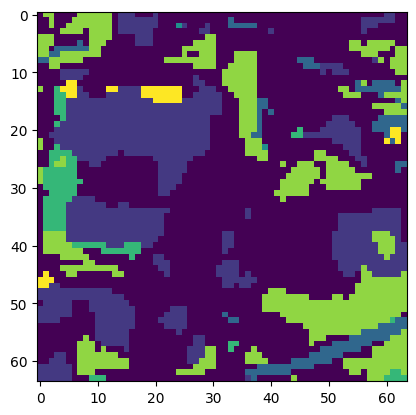

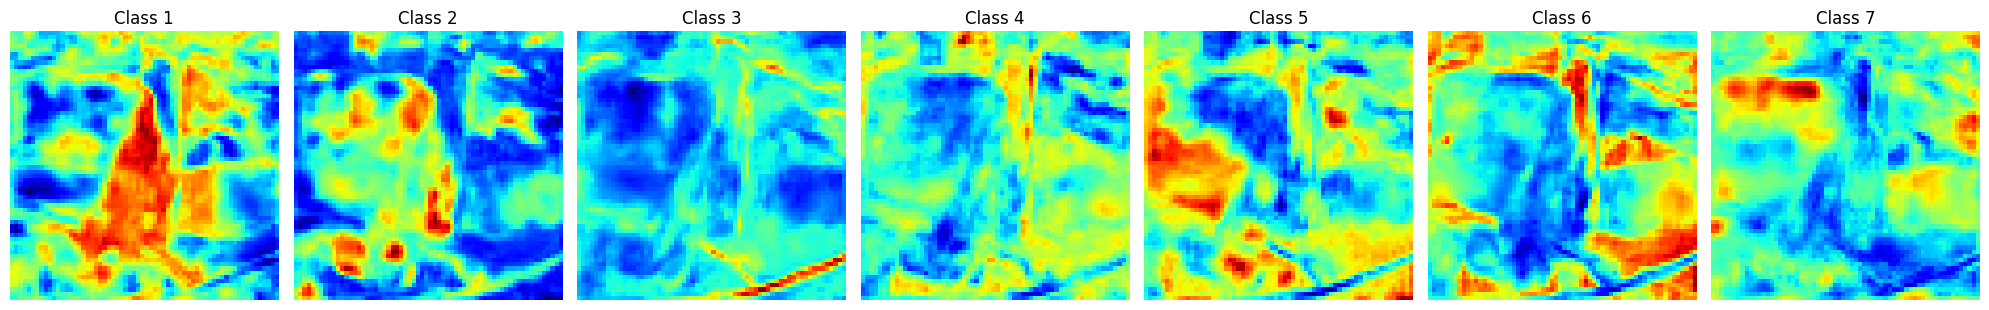

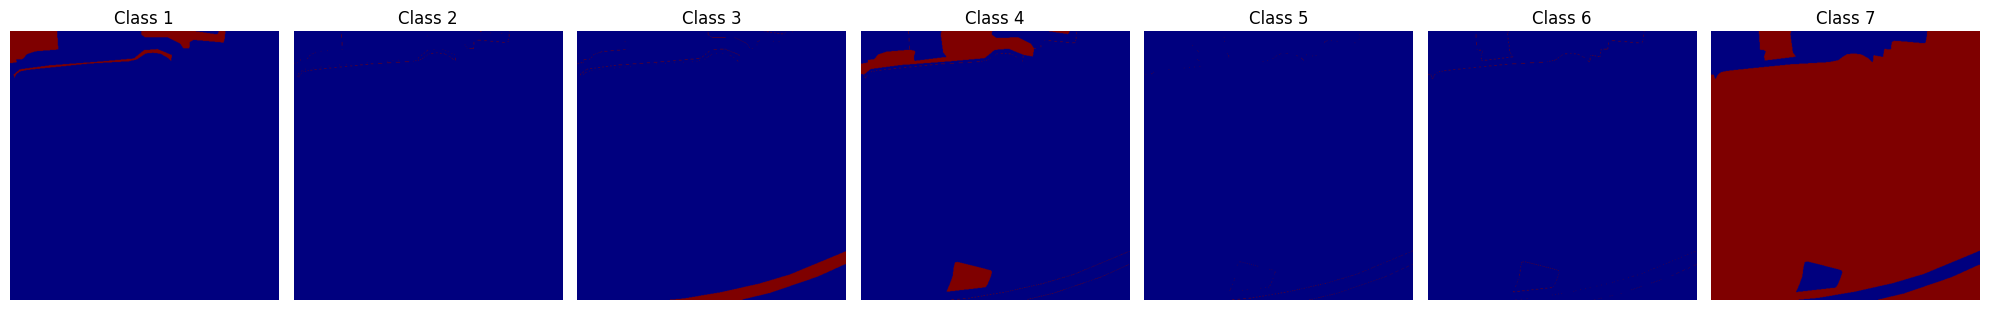

In [19]:
TRAINING=1
if TRAINING:  # Ensure you have a condition for training mode
    # Pick a random batch from the train loader
    a, b = val_dataset[100]
    inputs, targets = a, b  # Assuming the loader returns (input, target) pairs

    # Move the inputs and targets to the same device as the model
    inputs, targets = inputs.to(device), targets.to(device)

    inputs = inputs.unsqueeze(0)  # Add a batch dimension

    # Get the model output for the input
    model.eval()  # Make sure the model is in evaluation mode
    with torch.no_grad():
        output = model(inputs)  # Get model prediction for the input

    output = output[1]

    # Print the random input, output, and ground truth
    print("\nRandom Sample (Epoch {})".format(i))
    print("Input Tensor: ", inputs.shape)
    print("Ground Truth: ", targets.shape)
    print("Model Output: ", len(output))

    show_image(a)

    plt.imshow(b.argmax(dim=0)) #grouth truth mask
    plt.show()

    output = output.squeeze(0)

    plt.imshow(output.cpu().argmax(dim=0).numpy()) #

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = output[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 7, figsize=(20, 5))

    # Itera attraverso i canali della maschera (7 classi)
    for i in range(7):
        # Estrai il canale i-esimo
        mask_class = targets[i].cpu().numpy()  # Converti in array numpy per la visualizzazione

        # Visualizza la maschera della classe i
        axes[i].imshow(mask_class, cmap='jet')  # Usa una mappa di colori (ad esempio, 'jet')
        axes[i].set_title(f'Class {i + 1}')
        axes[i].axis('off')  # Disabilita gli assi

    # Mostra il risultato
    plt.tight_layout()
    plt.show()

    model.train()

In [20]:
# --- Calcolo della Loss ---
criterion = torch.nn.CrossEntropyLoss()  # Definisci la funzione di perdita
# La loss richiede che il target sia di tipo (B, H, W), quindi rimuovi il one-hot encoding
targets_class = targets.argmax(dim=0).unsqueeze(0)  # Ground truth in formato (B, H, W)

# --- Upsample l'output del modello ---
# Porta l'output del modello alla stessa risoluzione del target (512 x 512)
output_resized = F.interpolate(output.unsqueeze(0), size=targets_class.shape[1:], mode='bilinear', align_corners=False)

loss = criterion(output_resized, targets_class)  # Calcola la loss

print(f"Loss per l'immagine corrente: {loss.item()}")

# --- Calcolo della mIoU ---
def compute_miou(pred_mask, true_mask, num_classes):
    iou_list = []
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)  # Predizione per la classe cls
        true_cls = (true_mask == cls)  # Ground truth per la classe cls

        intersection = (pred_cls & true_cls).sum().item()
        union = (pred_cls | true_cls).sum().item()

        if union == 0:
            iou = float('nan')  # Evita la divisione per zero
        else:
            iou = intersection / union

        iou_list.append(iou)

    miou = torch.tensor(iou_list).nanmean().item()  # Calcola la media ignorando NaN
    return miou

# Calcola la mIoU
predicted_mask_resized = output_resized.squeeze(0).argmax(dim=0).cpu()  # Maschera predetta upscalata
true_mask = targets_class.squeeze(0).cpu()  # Ground truth
num_classes = 7  # Numero di classi

miou = compute_miou(predicted_mask_resized, true_mask, num_classes)
print(f"Mean IoU per l'immagine corrente: {miou}")


Loss per l'immagine corrente: 8.100793838500977
Mean IoU per l'immagine corrente: 0.06644856184720993
